In [1]:
import os
import random
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
# The function get_label_from_par reads a .par file and returns 
# True if either the second or fourth item is not 'nan', 
# indicating the presence of an E-region in the corresponding image,
# for use in binary classification.

def get_label_from_par(par_file_path):
    try:
        # Open the .par file located at par_file_path
        with open(par_file_path, 'r') as file:
            content = file.readline().strip()  # Read and strip the first line of the file
            items = content.split()  # Split the line into individual items (usually numbers or 'nan')

            # Check the second (index 1) and fourth (index 3) items:
            # If either of these items is not 'nan', it implies the presence of an E-region.
            # The function then returns True, indicating that this image has an E-region.
            is_e_region = items[1].lower() != 'nan' or items[3].lower() != 'nan'
        return is_e_region

    except IndexError:
        # This block catches an IndexError, which occurs if the line read from the file
        # does not have at least four items. In such a case, the function assumes that
        # the E-region data is not present or not properly formatted, and returns False.
        return False

    except Exception as e:
        # This block catches any other exceptions (like file not found, read errors, etc.).
        # It prints the exception message and returns False, indicating an issue with processing the file.
        print(f"Error reading {par_file_path}: {e}")
        return False

In [3]:
def get_majority_label(par_files):
    labels = [get_label_from_par(f) for f in par_files]
    if labels.count(True) > len(labels) / 2:
        return True
    elif labels.count(False) > len(labels) / 2:
        return False
    else:
        return random.choice([True, False])  # Randomize in case of a tie


In [4]:
def load_and_preprocess_image(image_path):
    image = load_img(image_path, color_mode='grayscale', target_size=(310, 310))
    image = img_to_array(image)
    image /= 255.0
    return image

In [5]:
def evaluate_models(models_dir, testing_dir):
    models = []
    for model_file in os.listdir(models_dir):
        if model_file.endswith('.h5'):
            models.append(load_model(os.path.join(models_dir, model_file)))

    ionograms_dir = os.path.join(testing_dir, 'ionograms')
    parameters_dir = os.path.join(testing_dir, 'parameters')

    X_test = []
    y_human = []

    for img_file in os.listdir(ionograms_dir):
        if img_file.endswith('.png'):
            img_path = os.path.join(ionograms_dir, img_file)
            X_test.append(load_and_preprocess_image(img_path))

            timestamp = os.path.splitext(img_file)[0]
            par_files = [os.path.join(parameters_dir, f) for f in os.listdir(parameters_dir) if timestamp in f]
            y_human.append(get_majority_label(par_files))

    X_test = np.array(X_test)
    y_human = np.array(y_human).astype(int)
    
    # Initialize lists to store metrics for each model
    precisions = []
    recalls = []
    f1s = []
    accuracies = []
    confusion_matrices = []
    
    for model in models:
        y_pred = model.predict(X_test).round().astype(int)
        precision = precision_score(y_human, y_pred)
        precisions.append(precision)
        recall = recall_score(y_human, y_pred)
        recalls.append(recall)
        f1 = f1_score(y_human, y_pred)
        f1s.append(f1)
        accuracy = accuracy_score(y_human, y_pred)
        accuracies.append(accuracy)
        y_pred = model.predict(X_test).round().astype(int)
        cm = confusion_matrix(y_human, y_pred, normalize='true')  # Normalized confusion matrix
        confusion_matrices.append(cm)
                
    # Calculate and print the mean and standard deviation of the metrics
    print(f"Mean Precision: {np.mean(precisions):.3f}, Std Precision: {np.std(precisions):.3f}")
    print(f"Mean Recall: {np.mean(recalls):.3f}, Std Recall: {np.std(recalls):.3f}")
    print(f"Mean F1-Score: {np.mean(f1s):.3f}, Std F1-Score: {np.std(f1s):.3f}")
    print(f"Mean Accuracy: {np.mean(accuracies):.3f}, Std Accuracy: {np.std(accuracies):.3f}")
    return confusion_matrices

In [6]:
models_dir = 'E-classify'
testing_dir = 'testing'
evaluate_models(models_dir, testing_dir)

Metal device set to: Apple M1 Max


2023-11-28 18:05:17.651739: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-28 18:05:17.651906: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-28 18:05:27.239596: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-28 18:05:27.373949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 90ms/step
Model: sequential_4 - Precision: 0.9546485260770975, Recall: 0.9836448598130841, F1: 0.9689298043728424, Accuracy: 0.9587786259541985


2023-11-28 18:05:31.693707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 92ms/step
Model: sequential_1 - Precision: 0.9546485260770975, Recall: 0.9836448598130841, F1: 0.9689298043728424, Accuracy: 0.9587786259541985


2023-11-28 18:05:36.147115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 88ms/step
Model: sequential_5 - Precision: 0.9691943127962085, Recall: 0.955607476635514, F1: 0.9623529411764705, Accuracy: 0.9511450381679389


2023-11-28 18:05:40.517736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 91ms/step
Model: sequential_2 - Precision: 0.9720930232558139, Recall: 0.9766355140186916, F1: 0.9743589743589743, Accuracy: 0.966412213740458


2023-11-28 18:05:44.865996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 89ms/step
Model: sequential_3 - Precision: 0.9502262443438914, Recall: 0.9813084112149533, F1: 0.9655172413793103, Accuracy: 0.9541984732824428
Mean Precision: 0.960, Std Precision: 0.009
Mean Recall: 0.976, Std Recall: 0.011
Mean F1-Score: 0.968, Std F1-Score: 0.004
Mean Accuracy: 0.958, Std Accuracy: 0.005


[array([[0.91189427, 0.08810573],
        [0.01635514, 0.98364486]]),
 array([[0.91189427, 0.08810573],
        [0.01635514, 0.98364486]]),
 array([[0.94273128, 0.05726872],
        [0.04439252, 0.95560748]]),
 array([[0.94713656, 0.05286344],
        [0.02336449, 0.97663551]]),
 array([[0.9030837 , 0.0969163 ],
        [0.01869159, 0.98130841]])]

In [7]:
confusion_matrices = evaluate_models(models_dir, testing_dir)

# Convert list of confusion matrices to a 3D NumPy array for easier calculations
confusion_matrices = np.array(confusion_matrices)

# Calculate mean and std for TP, FN, FP, TN
mean_tp = np.mean(confusion_matrices[:, 1, 1])
std_tp = np.std(confusion_matrices[:, 1, 1])

mean_fn = np.mean(confusion_matrices[:, 1, 0])
std_fn = np.std(confusion_matrices[:, 1, 0])

mean_fp = np.mean(confusion_matrices[:, 0, 1])
std_fp = np.std(confusion_matrices[:, 0, 1])

mean_tn = np.mean(confusion_matrices[:, 0, 0])
std_tn = np.std(confusion_matrices[:, 0, 0])

# Metrics, means, and standard deviations
means = [mean_tp, mean_fn, mean_fp, mean_tn]
std_devs = [std_tp, std_fn, std_fp, std_tn]

2023-11-28 18:06:15.611015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 77ms/step
Model: sequential_4 - Precision: 0.963718820861678, Recall: 0.9770114942528736, F1: 0.9703196347031964, Accuracy: 0.9603053435114504


2023-11-28 18:06:19.590986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 82ms/step
Model: sequential_1 - Precision: 0.9591836734693877, Recall: 0.9724137931034482, F1: 0.9657534246575341, Accuracy: 0.9541984732824428


2023-11-28 18:06:23.719009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 83ms/step
Model: sequential_5 - Precision: 0.981042654028436, Recall: 0.9517241379310345, F1: 0.9661610268378064, Accuracy: 0.9557251908396946


2023-11-28 18:06:27.988407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 82ms/step
Model: sequential_2 - Precision: 0.9790697674418605, Recall: 0.967816091954023, F1: 0.9734104046242775, Accuracy: 0.9648854961832061


2023-11-28 18:06:32.144619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 2s 77ms/step
Model: sequential_3 - Precision: 0.9615384615384616, Recall: 0.9770114942528736, F1: 0.9692132269099203, Accuracy: 0.9587786259541985
Mean Precision: 0.969, Std Precision: 0.009
Mean Recall: 0.969, Std Recall: 0.009
Mean F1-Score: 0.969, Std F1-Score: 0.003
Mean Accuracy: 0.959, Std Accuracy: 0.004


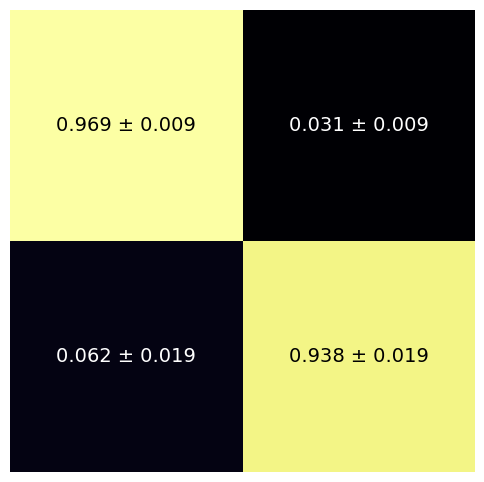

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Define a function to determine text color based on background color intensity
def text_color_based_on_bg(bg_color):
    # Calculate the perceptual luminance of the color
    luminance = (0.299*bg_color[0] + 0.587*bg_color[1] + 0.114*bg_color[2])
    return 'white' if luminance < 0.5 else 'black'

# Setup color map
cmap = plt.cm.inferno
norm = mcolors.Normalize(vmin=min(means), vmax=max(means))

# Create figure
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()

for i, ax in enumerate(axs):
    # Set the color based on the mean value
    color = cmap(norm(means[i]))
    
    # Create a colored square
    ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
    
    # Determine text color based on background color
    text_color = text_color_based_on_bg(color)
    
    # Add text for mean ± std deviation
    text = f'{means[i]:.3f} ± {std_devs[i]:.3f}'
    ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=14, color=text_color)
    
    # Remove axes
    ax.axis('off')

# Adjust layout so squares touch each other
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()